# Neural Artistic Style Transfer
This notebook uses neural transfer to provide a style to an content image. It is based on the papers [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) and [Semantic Style Transfer and Turning Two-Bit Doodles into Fine Artworks](https://arxiv.org/abs/1603.01768).

In this project, you learn how to implement a neural style transfer network. In the following list all steps are defined:
- [Load Data](#load-data)
- [Define Loss Functions](#define-loss-functions)
    - [Content Loss](#content-loss)
    - [Style Loss](#style-loss)
- [Load Pre-Trained Model](#load-pre-trained-model)
    - [Normalize and Combining Models](#normalization-and-combine-models)
- [Prepare Initial Image](#prepare-initial-image)
- [Gradient Descent and Optimizer](#gradient-descent-and-optimizer)
- [Define Hyperparameter and Run Model](#define-hyperparameter-and-run-model)

In [1]:
import os
import torch # ai model framework
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt # needed for showing images

import torchvision.transforms as transforms
import torchvision.models as models # imports our vgg-19 pretrained model

First of all, this code is based on pytorch. Pytorch a framework for developing ai models. It focus on calculating directly on the tensors. But there are also other frameworks such as tensorflow, lasagne, etc. available. Additionally, we check if a gpu is availabe and if we can use cuda. This would process our calculations much faster. (see [Understanding CUDA](https://medium.com/@rakeshrajpurohit/understanding-cuda-for-gpu-computing-330fa792ca1c)). 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Data
We need to load our images using pytorch in order to have it available in a correct (tensor) object. Instead of the regular values between 0 and 255, the torch tensors change the values between 0 and 1. **You need to adjust the paths to use your own images which should be processed.** **It is important that style and content images have the same size.** 512x12 is recommended.

In [3]:
# desired size of the output image
imsize = 512 #if torch.cuda.is_available() else 126  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions (VGG19)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [72]:
STYLE_IMG_PATH = "abstract-art-face.jpg"
CONTENT_IMG_PATH = "forrest.jpg"

In [73]:
style_img = image_loader(os.path.join('input', STYLE_IMG_PATH))
content_img = image_loader(os.path.join('input',CONTENT_IMG_PATH))

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, we visualize our loaded images using the [matplotlib](https://matplotlib.org/) package. Because we loaded the images in tensor objects, we have to remove the batch dimension using a torch method which is called `unload.

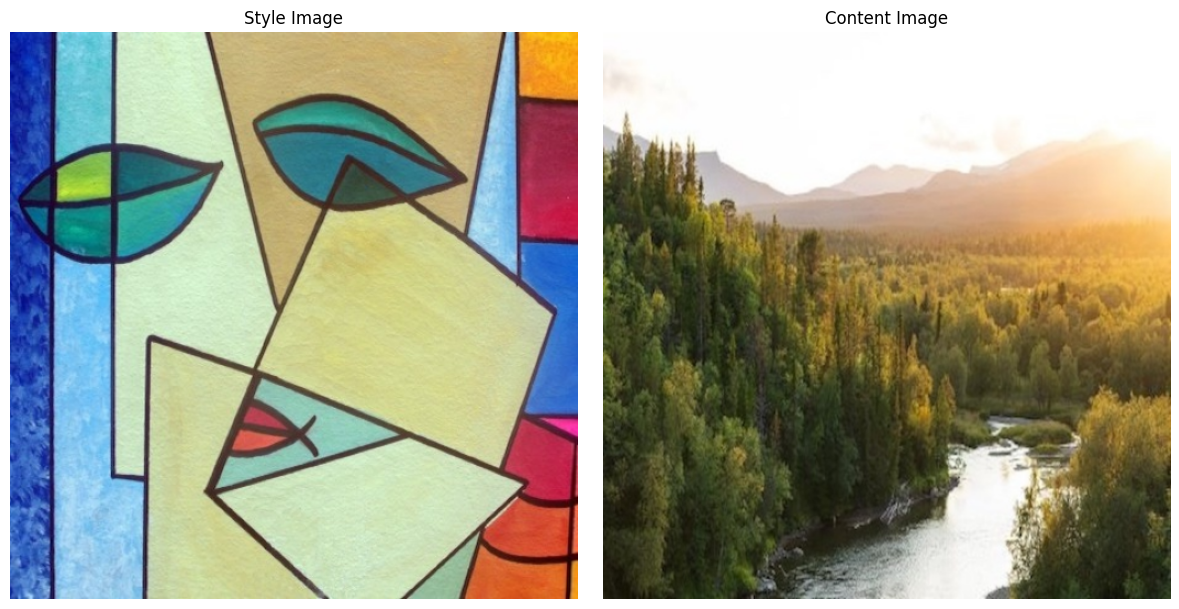

In [74]:
unloader = transforms.ToPILImage()  # convert into PIL image
# prepare figure to fit 2 images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

 
# remove the fake batch dimension
style_image_show = unloader(style_img.cpu().clone().squeeze(0))
axs[0].imshow(style_image_show)
axs[0].set_title('Style Image')
axs[0].axis('off')

content_img_show = unloader(content_img.cpu().clone().squeeze(0))
axs[1].imshow(content_img_show)
axs[1].set_title('Content Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Define Loss Functions
In this section, we prepare our pretained model, as well as the loss functions. We need to implement two different loss functions, one for the style loss and extraction of the texture feature and the content loss.

### Content Loss
The content loss is simpler one in this project. We are using a custom loss from pytorch. As loss function, the Mean Squared Error (MSE) is used. Pytorch has a `mse_loss` function already available, so that we don't have to take care of that. Nevertheless, we need to understand what our loss function is doing, even though we don't implement it by ourself. In detail, the MSE compares the estimated and real values from a whole batch using a square of the error. Here you can see the formula for that: 

$MSE = \frac{1}{n}\sum_{i=1}^n(Y_{i} - \hat{Y}_{i})^2$

$Y_{i}$ = real label

$\hat{Y}_{i}$ = predicted label

This may look very mathematical to you. In simple words, it calculates the error between the real value and the predicted one. So when thinking of Y and Y^ a vector and we calculate the distance between two vectors. The square is used to eliminated problems with negative signs.

In [75]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss
Our style loss method is more complex because we don't care about what the image is showing, but what the texture and techniques are. For that we are using the Gram matrix calculation. A interesting video explaining it in detail can be found [here](https://www.youtube.com/watch?v=Elxnzxk-AUk&ab_channel=DevelopersHutt). 

In simple words, it tries to find interesting and important patterns in our pictures. This is done by checking the image matrix (every pixel is a number). In the next code block, you can see how such pixel matrix looks like. There are 3 different channels too (because we have a RGB file).

In [76]:
print("Size of Image matrix:", content_img.shape)
content_img

Size of Image matrix: torch.Size([1, 3, 512, 512])


tensor([[[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.1686, 0.1451, 0.1216,  ..., 0.1765, 0.1725, 0.1725],
          [0.1725, 0.1490, 0.1294,  ..., 0.1922, 0.1922, 0.1882],
          [0.1725, 0.1451, 0.1294,  ..., 0.2078, 0.2078, 0.2039]],

         [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.1608, 0.1373, 0.1137,  ..., 0.2353, 0.2314, 0.2314],
          [0.1647, 0.1412, 0.1216,  ..., 0.2510, 0.2510, 0.2471],
          [0.1647, 0.1373, 0.1216,  ..., 0.2667, 0.2667, 0.2627]],

         [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1

In [77]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # By dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [78]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Load Pre-Trained Model
In this example, a pretrained [VVG19](https://arxiv.org/abs/1409.1556) Model is used. Luckily, pytorch is also taking care of pretained models. So we load our pretrained model. Pretraining means that the model already knows some common structures. It knows categories such as goldfish, person, car,... This is done with a very popular dataset called [ImageNet](https://www.image-net.org/). For completety, here you can see the architecture of the model.  


![VVG19 Layers](../material/vvg19.png)

In [79]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Normalization and Combining Models
Here you can see a combination model for our content and style calculations. It includes not only normalization of the cnn, but also a combination of the two loss functions. This produces our desired output image. 

We need to normalize our model with meand and standard deviation in order to have the following shape: $B x C x H x W$. 

$B$ = batch size


$C$ = channels


$H x W$ = height and width

Additionally, VGG networks are trained on images with each channel
normalized by `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`.
We will use them to normalize the image before sending it into the network.

In [80]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.

In [81]:
# desired depth layers to compute style/content losses:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    # we iterate over all of the existing layers
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Prepare Initial Image

Normally, it is better to start of with the content image as initial image. But you could also start with white noise and combine the images at random. Therefore this block can be uncommended.

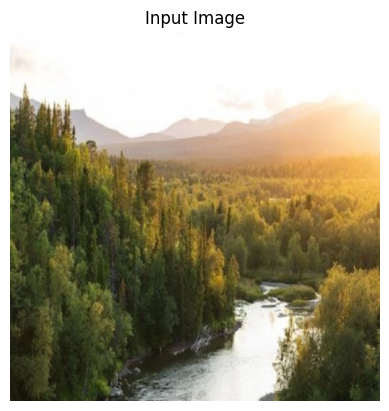

In [82]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
# remove the fake batch dimension
input_img_show = unloader(input_img.cpu().clone().squeeze(0))
plt.imshow(input_img_show)
plt.title('Input Image')
plt.axis('off')
plt.show()

## Gradient Descent and Optimizer
We are using the method of gradient descent to find the minimum of our loss function (sum of content and style loss). This is done by using the dervative of the loss function. This is the reason why all loss function needs to be simple and derivable. Additional, we are using a optimizer, which is also provided by pytorch. In this notebook, we are using the Limited-memory BFGS. BFGS stands for Broyden-Fletcher-Goldfarb-Shanno algorithm. The most important fact about optimizer is, that it basically helps us finding the optimal combination of weights in our neural network.

In [83]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [84]:
def run(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            # summarizing style and content loss to a combined value
            loss = style_score + content_score
            # backprobagate and update weights in our model
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

## Define Hyperparameter and Run Model
In this model we can change basically two hyperparameters:
- `ratio`: defines how much style and content influence is in the image.
$\alpha/\beta$

$\alpha$ = influence of style on the output image

$\beta$ = influence of content on the output image

Here you can see a example of ratio usage:
![Example of ratio difference](../material/ratioExample.png)

- `num_steps`: defines how much iteration are done, till the image is finished. Of course, the more iterations we choose, the more detailed is our style in the content image. We need to find a nice tradeoff between computational time our model needs and the output image quality. 

In [85]:
# Hyperparameter
STYLE_WEIGHT = 1000000 # ratio how important style and content is
CONTENT_WEIGHT = 1
NUM_STEPS = 800 # recommended 500

Building the style transfer model..


/tmp/ipykernel_1982/1804555392.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1982/1804555392.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 145.602203 Content Loss: 12.582342

run [100]:
Style Loss : 38.293289 Content Loss: 11.598091

run [150]:
Style Loss : 17.627993 Content Loss: 11.279184

run [200]:
Style Loss : 9.804983 Content Loss: 10.638924

run [250]:
Style Loss : 6.145857 Content Loss: 10.073382

run [300]:
Style Loss : 4.434931 Content Loss: 9.570720

run [350]:
Style Loss : 3.355296 Content Loss: 9.206197

run [400]:
Style Loss : 2.570199 Content Loss: 8.957662

run [450]:
Style Loss : 2.009344 Content Loss: 8.752318

run [500]:
Style Loss : 1.653838 Content Loss: 8.568023

run [550]:
Style Loss : 1.412059 Content Loss: 8.417752

run [600]:
Style Loss : 1.245937 Content Loss: 8.297340

run [650]:
Style Loss : 1.131605 Content Loss: 8.200899

run [700]:
Style Loss : 1.043752 Content Loss: 8.118250

run [750]:
Style Loss : 0.985893 Content Loss: 8.050301

run [800]:
Style Loss : 0.933349 Content Loss: 7.996219



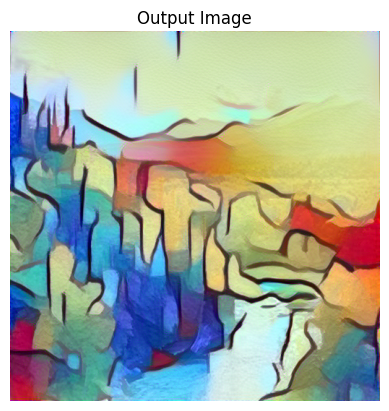

In [86]:
output = run(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img=content_img, style_img= style_img, input_img= input_img, num_steps=NUM_STEPS, style_weight = STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)

plt.figure()
output_show = unloader(output.cpu().clone().squeeze(0))
plt.imshow(output_show)
plt.title('Output Image')
plt.axis('off')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.savefig(os.path.join('output', CONTENT_IMG_PATH))
plt.show()

Finally, we can show the output image and we can save our master piece in the `/output` directory.